# Simulate data
This notebook generates simulated experiments by sampling from the VAE using the user selected template experiment as a guide for sampling

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import umap
from keras.models import load_model
from sklearn.decomposition import PCA
import pickle

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

from ponyo import utils, generate_template_data

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_compendium_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

shared_genes_file = os.path.join(
    local_dir,
    "shared_gene_ids.pickle")

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))
shared_genes = pickle.load(open(shared_genes_file, "rb"))

In [4]:
# Read data
compendium = pd.read_csv(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

normalized_compendium = pd.read_csv(
    normalized_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

### Simulate experiments using selected template experiment

In [5]:
# Simulate experiments
# Make sure range is correct
# Generate multiple simulated datasets
for i in range(num_runs):
    generate_template_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        i)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# Truncate simulated experiments
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

for i in range(num_runs):
    simulated_data_file = os.path.join(
        local_dir, 
        "pseudo_experiment",
        "selected_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    # Read simulated data
    simulated_data = pd.read_csv(
        simulated_data_file,
        header=0,
        sep='\t',
        index_col=0)
    
    # Drop samples
    simulated_data = simulated_data.drop(smRNA_samples)
    # Drop genes
    #simulated_data = simulated_data[shared_genes]
    
    # Save 
    simulated_data.to_csv(simulated_data_file, float_format='%.5f', sep='\t')

### Quick validation of simulated experiments

**Spot check expression values**
1. Values are different between different simulated data files (meaning it was a different simulated dataset), and different from the template experiment
2. Range of values is scaled the same as the compendium

In [7]:
# Compendium
print(compendium.shape)
compendium.head()

(3388, 17788)


,BTNL8,LINC01134,HEATR4,ACO1,PLPP3,STX6,TAX1BP1,UCN,ZNF667,OXNAD1,...,SELP,COL24A1,FOSB,SLC15A3,ADAM29,GSTM4,B2M,ANOS1,ARL2BP,DDA1
SRR493816,0.009,0.356,0.214,4.646,1.227,7.634,4.465,2.064,0.035,1.358,...,0.020,0.001,1.373,0.962,0.000,1.010,87.853,0.103,17.299,14.263
SRR493817,0.000,0.310,0.228,3.903,1.867,7.212,3.578,1.701,0.020,1.631,...,0.021,0.001,2.359,1.155,0.000,0.731,90.089,0.145,11.214,13.188
SRR547975,0.000,0.279,0.000,11.200,2.314,7.241,9.227,2.583,0.000,1.758,...,0.000,0.000,7.344,0.132,0.000,0.056,107.449,0.262,40.584,9.344
SRR547973,0.030,0.029,0.268,4.864,1.538,8.165,33.185,1.200,0.000,2.170,...,0.000,0.012,0.100,0.038,0.000,3.942,120.775,0.000,12.072,5.163
SRR547968,13.664,0.449,0.086,15.993,0.339,7.116,19.765,0.716,0.000,1.996,...,0.000,0.000,0.207,0.003,0.004,5.721,288.932,0.000,18.370,8.025


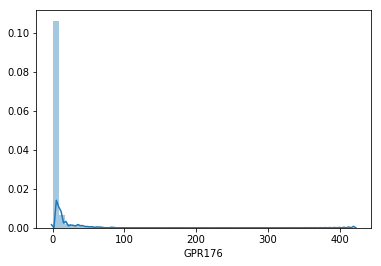

In [8]:
sns.distplot(compendium['GPR176'])

In [9]:
# Template experiment
print(template_data.shape)
template_data.head()

(24, 17788)


,BTNL8,LINC01134,HEATR4,ACO1,PLPP3,STX6,TAX1BP1,UCN,ZNF667,OXNAD1,...,SELP,COL24A1,FOSB,SLC15A3,ADAM29,GSTM4,B2M,ANOS1,ARL2BP,DDA1
SRR493937,0.31629,0.03766,0.27126,7.68085,35.58117,5.36716,10.24876,1.07801,0.35476,2.25323,...,8.49746,0.29897,272.00049,25.30218,0.02680,2.99666,605.44324,9.01530,17.38694,8.38628
SRR493938,0.21191,0.08980,0.27026,7.78364,34.70918,5.17130,9.80050,0.95223,0.33620,2.22372,...,8.85404,0.25529,272.93174,25.83916,0.03931,3.03284,606.45636,8.75897,17.45530,8.53377
SRR493939,0.03195,0.18018,0.24293,3.67414,9.25606,10.15101,19.15632,1.00572,0.15159,1.09575,...,2.00930,0.47513,43.86723,8.34718,0.03558,2.53270,254.69065,13.16709,17.18696,5.41856
SRR493940,0.07287,0.18879,0.30247,3.47172,9.36842,9.85215,18.71897,0.77388,0.14550,0.95707,...,2.02684,0.45421,44.42775,8.11901,0.03014,2.23827,253.58414,13.82790,16.38128,5.41806
SRR493941,0.31407,0.08936,0.21171,6.00336,53.38678,5.57894,9.29956,1.29233,0.41843,0.91351,...,15.98251,0.21070,127.57439,15.74434,0.14894,2.57159,314.15619,26.32524,27.20674,8.49858


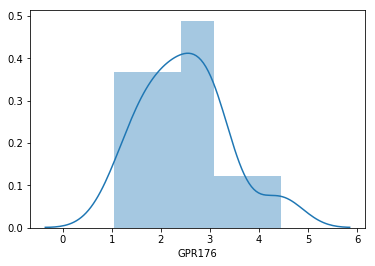

In [10]:
sns.distplot(template_data['GPR176'])

In [11]:
# Manual select one simulated experiment
simulated_file_1 = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_"+project_id+"_0.txt")

# Read data
simulated_test_1 = pd.read_csv(
    simulated_file_1,
    header=0,
    sep='\t',
    index_col=0)

print(simulated_test_1.shape)
simulated_test_1.head()

(24, 17788)


,BTNL8,LINC01134,HEATR4,ACO1,PLPP3,STX6,TAX1BP1,UCN,ZNF667,OXNAD1,...,SELP,COL24A1,FOSB,SLC15A3,ADAM29,GSTM4,B2M,ANOS1,ARL2BP,DDA1
SRR493937,0.248,0.053,0.215,3.346,8.686,4.044,11.327,0.753,0.131,1.649,...,2.932,0.468,18.111,7.850,0.013,2.492,399.021,0.564,13.090,6.446
SRR493938,0.249,0.053,0.215,3.343,8.683,4.037,11.246,0.748,0.130,1.644,...,2.955,0.464,18.227,7.873,0.013,2.501,396.456,0.568,13.145,6.466
SRR493939,1.466,0.122,0.203,5.357,8.868,6.110,16.267,1.200,0.250,1.941,...,1.226,0.313,10.638,6.723,0.036,3.652,396.894,1.206,18.894,6.290
SRR493940,1.481,0.122,0.203,5.361,8.891,6.104,16.299,1.196,0.250,1.941,...,1.232,0.314,10.578,6.666,0.036,3.643,397.087,1.209,18.875,6.282
SRR493941,0.436,0.084,0.251,4.289,11.215,4.685,11.666,1.284,0.194,1.600,...,2.076,0.253,30.541,4.788,0.037,2.189,273.542,1.298,15.982,6.566


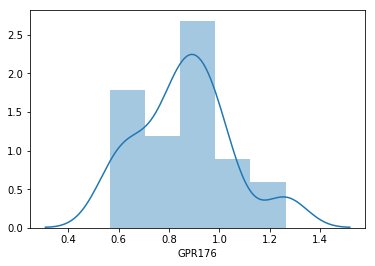

In [12]:
sns.distplot(simulated_test_1['GPR176'])

In [13]:
# Manual select another simulated experiment
simulated_file_2 = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_"+project_id+"_10.txt")

# Read data
simulated_test_2 = pd.read_csv(
    simulated_file_2,
    header=0,
    sep='\t',
    index_col=0)

print(simulated_test_2.shape)
simulated_test_2.head()

(24, 17788)


,BTNL8,LINC01134,HEATR4,ACO1,PLPP3,STX6,TAX1BP1,UCN,ZNF667,OXNAD1,...,SELP,COL24A1,FOSB,SLC15A3,ADAM29,GSTM4,B2M,ANOS1,ARL2BP,DDA1
SRR493937,0.534,0.162,0.395,6.186,4.898,5.503,14.765,0.740,0.080,3.566,...,0.742,0.307,11.543,3.649,0.015,5.103,227.495,0.454,20.914,6.911
SRR493938,0.531,0.162,0.394,6.159,4.885,5.492,14.682,0.745,0.080,3.557,...,0.746,0.307,11.604,3.669,0.015,5.097,226.552,0.454,20.860,6.935
SRR493939,2.012,0.294,0.350,6.720,5.335,6.355,15.750,1.882,0.148,3.493,...,0.285,0.197,8.942,2.185,0.032,4.856,185.914,0.806,22.047,8.257
SRR493940,1.993,0.293,0.349,6.730,5.343,6.361,15.814,1.851,0.147,3.494,...,0.281,0.197,8.788,2.170,0.032,4.836,185.418,0.802,22.063,8.243
SRR493941,0.486,0.192,0.391,6.120,6.335,5.170,15.387,1.109,0.106,3.191,...,0.446,0.189,10.306,2.094,0.021,4.417,140.670,0.709,23.778,8.319


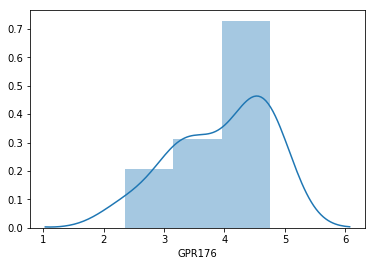

In [14]:
sns.distplot(simulated_test_2['GPR176'])

**Check clustering of simulated samples**

Check PCA embedding of original experiment and simulated experiments. We expect to see a similar structure in the template and simulated experiments. Also expect to see that the simulated experiment follows the distribution of the compendium.

In [15]:
# Load VAE models
model_encoder_file = glob.glob(os.path.join(
        NN_dir,
        "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
pca = PCA(n_components=2)

In [17]:
# Embedding of real compendium (encoded)

# Scale compendium
#compendium_scaled = scaler.transform(compendium)
#compendium_scaled_df = pd.DataFrame(compendium_scaled,
#                                    columns=compendium.columns,
#                                    index=compendium.index)

# Encode normalized compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=compendium.index)

# Get and save PCA model
model = pca.fit(compendium_encoded_df)

compendium_PCAencoded = model.transform(compendium_encoded_df)

compendium_PCAencoded_df = pd.DataFrame(data=compendium_PCAencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_PCAencoded_df['experiment_id'] = 'background'

In [18]:
# Embedding of real template experiment (encoded)

# Scale template data
template_data_scaled = scaler.transform(template_data)
template_data_scaled_df = pd.DataFrame(template_data_scaled,
                                    columns=template_data.columns,
                                    index=template_data.index)

# Encode template experiment into latent space
template_encoded = loaded_model.predict_on_batch(template_data_scaled_df)
template_encoded_df = pd.DataFrame(data=template_encoded,
                                   index=template_data.index)

template_PCAencoded = model.transform(template_encoded_df)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_PCAencoded_df['experiment_id'] = 'template_experiment'

**Visualization in latent space**

In [19]:
encoded_simulated_file = os.path.join(local_dir,
    "pseudo_experiment",
    "selected_simulated_encoded_data_"+project_id+"_10.txt")

In [20]:
# Embedding of simulated experiment (encoded)

simulated_encoded_df = pd.read_csv(
    encoded_simulated_file,
    header=0,
    sep='\t',
    index_col=0)

# Drop samples
simulated_encoded_df = simulated_encoded_df.drop(smRNA_samples)

simulated_PCAencoded = model.transform(simulated_encoded_df)

simulated_PCAencoded_df = pd.DataFrame(data=simulated_PCAencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_PCAencoded_df['experiment_id'] = 'simulated_experiment'

In [21]:
# Concatenate dataframes
combined_PCAencoded_df = pd.concat([compendium_PCAencoded_df, 
                                    template_PCAencoded_df,
                                    simulated_PCAencoded_df])

print(combined_PCAencoded_df.shape)
combined_PCAencoded_df.head()

(3436, 3)


,1,2,experiment_id
SRR493816,-0.387871,-3.884161,background
SRR493817,-0.662979,-3.465846,background
SRR547975,3.841993,-4.426712,background
SRR547973,0.027453,1.373091,background
SRR547968,-0.858481,-0.850396,background


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


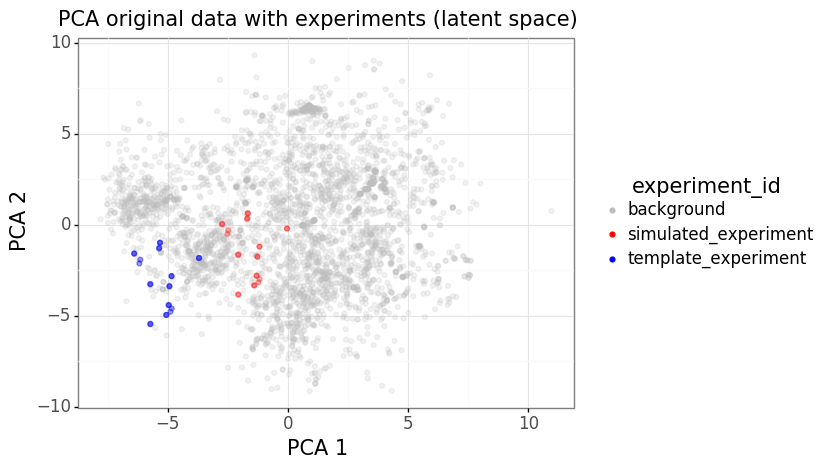

<ggplot: (8748313754185)>


In [22]:
# Plot
fig = ggplot(combined_PCAencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.1, 
                  color='red')

print(fig)

**Visualization in latent space (re-encoded)**

In [23]:
# Embedding of simulated experiment (encoded)

# Scale simulated data
simulated_test_2_scaled = scaler.transform(simulated_test_2)
simulated_test_2_scaled_df = pd.DataFrame(simulated_test_2_scaled,
                                          columns=simulated_test_2.columns,
                                          index=simulated_test_2.index)

# Encode simulated experiment into latent space
simulated_encoded = loaded_model.predict_on_batch(simulated_test_2_scaled_df)
simulated_encoded_df = pd.DataFrame(simulated_encoded, 
                                    index=simulated_test_2.index)

simulated_PCAencoded = model.transform(simulated_encoded_df)

simulated_PCAencoded_df = pd.DataFrame(data=simulated_PCAencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_PCAencoded_df['experiment_id'] = 'simulated_experiment'

In [24]:
# Concatenate dataframes
combined_PCAencoded_df = pd.concat([compendium_PCAencoded_df, 
                                    template_PCAencoded_df,
                                    simulated_PCAencoded_df])

print(combined_PCAencoded_df.shape)
combined_PCAencoded_df.head()

(3436, 3)


,1,2,experiment_id
SRR493816,-0.387871,-3.884161,background
SRR493817,-0.662979,-3.465846,background
SRR547975,3.841993,-4.426712,background
SRR547973,0.027453,1.373091,background
SRR547968,-0.858481,-0.850396,background


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


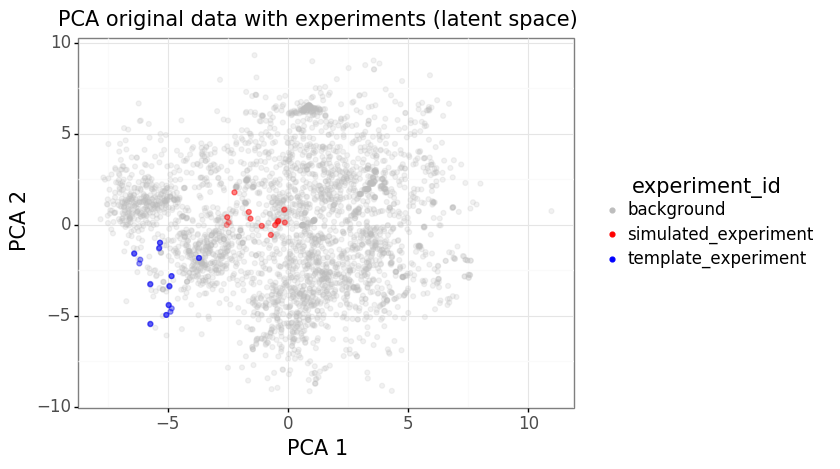

<ggplot: (8748313766725)>


In [25]:
# Plot
fig = ggplot(combined_PCAencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_PCAencoded_df[combined_PCAencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.1, 
                  color='red')

print(fig)

**Visualization in gene space**

In [26]:
# Embedding of real compendium

# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_compendium)

compendium_UMAPencoded = model.transform(normalized_compendium)

compendium_UMAPencoded_df = pd.DataFrame(data=compendium_UMAPencoded,
                                         index=normalized_compendium.index,
                                         columns=['1','2'])
# Add label
compendium_UMAPencoded_df['experiment_id'] = 'background'

In [27]:
# Embedding of real template experiment

template_UMAPencoded = model.transform(template_data_scaled_df)

template_UMAPencoded_df = pd.DataFrame(data=template_UMAPencoded,
                                         index=template_data_scaled_df.index,
                                         columns=['1','2'])

# Add back label column
template_UMAPencoded_df['experiment_id'] = 'template_experiment'

In [28]:
# Embedding of simulated template experiment

simulated_UMAPencoded = model.transform(simulated_test_2_scaled_df)

simulated_UMAPencoded_df = pd.DataFrame(data=simulated_UMAPencoded,
                                         index=simulated_test_2_scaled_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_UMAPencoded_df['experiment_id'] = 'simulated_experiment'

In [29]:
# Concatenate dataframes
combined_UMAPencoded_df = pd.concat([compendium_UMAPencoded_df, 
                                    template_UMAPencoded_df,
                                    simulated_UMAPencoded_df])

combined_UMAPencoded_df.shape

(3436, 3)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


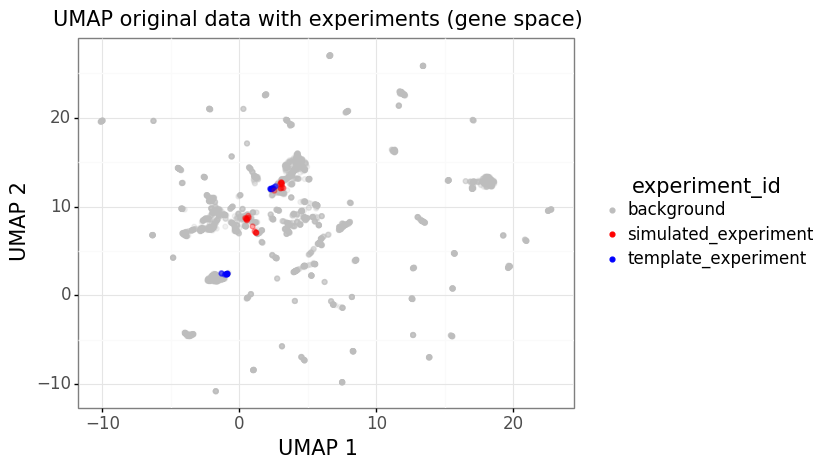

<ggplot: (8748314709473)>


In [30]:
# Plot
fig = ggplot(combined_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'UMAP original data with experiments (gene space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.2, 
                  color='red')

print(fig)

**Observation:**
The latent space encoded simulated data embedded into the first 2 PCs shows the linear shift of the simulated experiment compared to the template experiment, as expected. However, we noticed that the shift is fairly large and moves the experiment outside of the background distribution. This is something to consider for future iterations of this simulation.

The latent space visualization (re-encoded) is another visualization using PCA. In this case, the simulated data, which was shifted in the latent space and decoded into gene space, is encoded into latent space. We can see the shift fo the simulated data, however the relationship between samples are not an exact match to the template experiment because we have decoded the simulated data, which is a nonlinear transformation. This nonlinear transformation of the data is even more apparent when we embed the simulated data in gene space into UMAP space.